In [ ]:
!pip install pymoo

In [13]:
import pickle as p
import numpy as np
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
from scipy import stats

plt.rc('legend', fontsize=13)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=13)
plt.rcParams["font.family"] = "serif"

In [10]:
def get_hashKey(arch):
    """
    Get the key which is used to represent the architecture in "self.data".
    """
    return ''.join(map(str, arch))

def find_the_better(x, y):
    if isinstance(x, list):
        x = np.array(x)
    if isinstance(y, list):
        y = np.array(y)

    sub_ = x - y
    x_better = np.all(sub_ <= 0)
    y_better = np.all(sub_ >= 0)
    if x_better == y_better:  # True - True
        return -1
    if y_better:  # False - True
        return 1
    return 0  # True - False

def get_front_0(F):
    l = len(F)
    r = np.zeros(l, dtype=np.int8)
    for i in range(l):
        if r[i] == 0:
            for j in range(i + 1, l):
                better_sol = find_the_better(F[i], F[j])
                if better_sol == 0:
                    r[j] += 1
                elif better_sol == 1:
                    r[i] += 1
                    break
    return r == 0

def calculate_IGD(af):
    af = np.array(af)
    af[:, 1] = (af[:, 1] - min_FLOPs) / (max_FLOPs - min_FLOPs)
    af = np.round(af, 4)
    igd_value = IGD_computing(af)
    return igd_value


def calculate_HV(af):
    hv_value = HV_computing(af)
    return np.round(hv_value / np.prod(reference_point), 6)


def evaluate(list_arch):
    F = []
    for arch in list_arch:
        hashKey = get_hashKey(arch)
        test_error = np.round(1 - benchmark_data['200'][hashKey]['test_acc'][-1], 4)
        efficiency_metric = np.round(benchmark_data['200'][hashKey]['FLOPs'], 4)
        f = [test_error, efficiency_metric]
        F.append(f)

    F = np.array(F)
    list_arch = np.array(list_arch)
    fr0 = get_front_0(F)
    AF = F[fr0]
    AF = np.unique(AF, axis=0)
    AS = list_arch[fr0]
    igd_value = calculate_IGD(AF)
    hv_value = calculate_HV(AF)
    best_test_acc = np.round((1 - np.min(AF[:, 0])) * 100, 2)
    opt_results = {
        'Approximation Set': AS,
        'Approximation Front': AF,
        'IGD': igd_value,
        'HV': hv_value,
        'Best testing accuracy': best_test_acc,
    }
    return opt_results



def summarize_results():
    list_variant = [
        'train_loss', 'synflow',
        'ENAS_TFI', 'MOENAS_PSI', 'MOENAS_TF_PSI',
        'E-TF-MOENAS',
    ]
    for variant in list_variant:
        print('Algorithm:', variant)
        algo_res_path = f'{RES_PATH}/NAS201-C10_{variant}'

        list_rt = []
        list_approximation_front = []
        list_IGD = []
        list_HV = []
        list_exps = list(os.listdir(algo_res_path))
        for exp in list_exps:
            if exp == 'logging.txt':
                continue

            p_file_ = algo_res_path + f'/{exp}'

            E_Archive_search_each_gen = p.load(open(p_file_ + '/E_Archive_search_each_gen.p', 'rb'))
            final_ea = E_Archive_search_each_gen[-1]
            rs_evaluation = evaluate(final_ea['X'])

            ea = {
                'X_lst': rs_evaluation['Approximation Set'],
                'F_lst': rs_evaluation['Approximation Front'],
            }

            igd_value = rs_evaluation['IGD']
            hv_value = rs_evaluation['HV']

            list_approximation_front.append(ea)
            list_IGD.append(igd_value)
            list_HV.append(hv_value)

        rs = {
            'EA_all': list_approximation_front,
            'IGD_all': list_IGD,
            'HV_all': list_HV,
        }
        p.dump(rs, open(f'{RES_PATH}/raw_results_{variant}_{dataset_abbrev}_T.p', 'wb'))


def processing_results():
    list_variant = [
        'train_loss', 'synflow',
        'ENAS_TFI', 'MOENAS_PSI', 'MOENAS_TF_PSI',
        'E-TF-MOENAS',
    ]

    for variant in list_variant:
        res = p.load(open(f'{RES_PATH}/raw_results_{variant}_{dataset_abbrev}_T.p', 'rb'))

        best_arch_found = []
        final_EA = []
        final_IGD = []
        final_HV = []
        final_running_time = []

        n_runs = len(res['EA_all'])
        for i in range(n_runs):
            EA = res['EA_all'][i]
            F = EA['F_lst']
            best_arch = np.round((1 - np.min(F[:, 0])) * 100, 2)
            igd_value = res['IGD_all'][i]
            hv_value = res['HV_all'][i]

            best_arch_found.append(best_arch)
            final_IGD.append(igd_value)
            final_HV.append(hv_value)
            final_EA.append(EA)

        rs_final = {
            'best_arch_found': best_arch_found,
            'final_EA': final_EA,
            'final_IGD': final_IGD,
            'final_HV': final_HV,
        }
        p.dump(rs_final, open(f'{RES_PATH}/{variant}_{dataset_abbrev}_T.p', 'wb'))

## Summarize

In [2]:
RES_PATH = '/content/drive/MyDrive/Information_Sciences/nas201'  # Experiment Results Path
DATABASE_PATH = '/content/drive/MyDrive/Benchmark_Data/NASBench201'  # Database Path

In [52]:
dataset = 'ImageNet16-120'
if dataset == 'CIFAR-100':
    dataset_abbrev = 'C100'
else:
    dataset_abbrev = 'IN16'

In [53]:
benchmark_data = p.load(open(DATABASE_PATH + f'/[{dataset}]_data.p', 'rb'))
if dataset == 'CIFAR-100':
    opt_pareto_front = p.load(open(DATABASE_PATH + '/[POF_TestAcc_FLOPs]_[NAS201_cifar100].p', 'rb'))
    min_FLOPs, max_FLOPs = 7.78890, 220.12554  # CIFAR-100
    reference_point = [0.99 + 1e-4, 220.126 + 1e-4]
else:
    opt_pareto_front = p.load(open(DATABASE_PATH + '/[POF_TestAcc_FLOPs]_[NAS201_ImageNet16-120].p', 'rb'))
    min_FLOPs, max_FLOPs = 1.95340, 55.037560  # ImageNet16-120
    reference_point = [0.9917 + 1e-4, 47.173 + 1e-4]

opt_pareto_front[:, 0] /= 100
opt_pareto_front[:, 1] = np.round((opt_pareto_front[:, 1] - min_FLOPs) / (max_FLOPs - min_FLOPs), 4)
opt_pareto_front = np.round(opt_pareto_front, 6)

HV_computing = HV(reference_point)
IGD_computing = IGD(opt_pareto_front)

In [54]:
summarize_results()

Algorithm: train_loss
Algorithm: synflow
Algorithm: ENAS_TFI
Algorithm: MOENAS_PSI
Algorithm: MOENAS_TF_PSI
Algorithm: E-TF-MOENAS


In [55]:
processing_results()

## Visualize

In [49]:
def draw(metric):
    list_algo = ['train_loss', 'synflow', 'MOENAS_PSI', 'MOENAS_TF_PSI', 'ENAS_TFI', 'TF-MOENAS', 'E-TF-MOENAS']
    list_xticks = ['NSGA-II (train_loss)', 'NSGA-II (synflow)', 'MOENAS_PSI', 'MOENAS_TF_PSI', 'ENAS_TFI', 'TF-MOENAS', 'E-TF-MOENAS (Ours)']
    list_color = ['green', 'tab:orange', 'brown', 'black', 'tab:olive', 'tab:cyan', 'red']

    plt.grid(True, axis='y', linestyle='--', zorder=0)

    for i, algo in enumerate(list_algo):
        mean, std = algo_perf[dataset_abbrev][algo][metric]['mean'], algo_perf[dataset_abbrev][algo][metric]['std']
        (_, caps, _) = plt.errorbar(i, mean, yerr=std, fmt='.', capsize=10, linewidth=4, color=list_color[i], zorder=i+2, markersize=18, label=list_xticks[i])
        for cap in caps:
            cap.set_markeredgewidth(2)

    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    plt.title(metric + f' ({dataset})', fontsize=20)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

    plt.savefig(f'{RES_PATH}/201_{dataset_abbrev}_transfer_{metric}.jpg', bbox_inches='tight', pad_inches=0.1, dpi=300)


In [56]:
algo_perf = {
    'C100': {
        'TF-MOENAS': {
            'IGD': {'mean': 0.0413, 'std': 0.0152},
            'HV': {'mean': 0.6808, 'std': 0.0030}
        }
    },
    'IN16': {
        'TF-MOENAS': {
            'IGD': {'mean': 0.0252, 'std': 0.0134},
            'HV': {'mean': 0.4170, 'std': 0.0035}
        }
    },
}
list_algo = ['train_loss', 'synflow', 'MOENAS_PSI', 'MOENAS_TF_PSI', 'ENAS_TFI', 'E-TF-MOENAS']
for algo in list_algo:
    res = p.load(open(RES_PATH + f'/{algo}_{dataset_abbrev}_T.p', 'rb'))
    igd, hv = res['final_IGD'], res['final_HV']
    mean_igd, std_igd = np.round(np.mean(igd), 4), np.round(np.std(igd), 4)
    mean_hv, std_hv = np.round(np.mean(hv), 4), np.round(np.std(hv), 4)
    algo_perf[dataset_abbrev][algo] = {'IGD': {'mean': {}, 'std': {}}, 'HV': {'mean': {}, 'std': {}}}
    algo_perf[dataset_abbrev][algo]['IGD']['mean'] = mean_igd
    algo_perf[dataset_abbrev][algo]['IGD']['std'] = std_igd
    algo_perf[dataset_abbrev][algo]['HV']['mean'] = mean_hv
    algo_perf[dataset_abbrev][algo]['HV']['std'] = std_hv

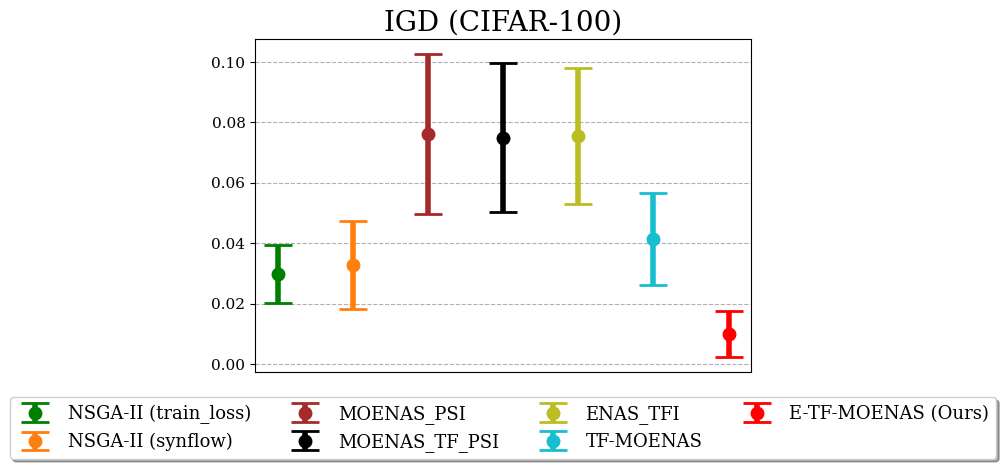

In [50]:
draw('IGD')

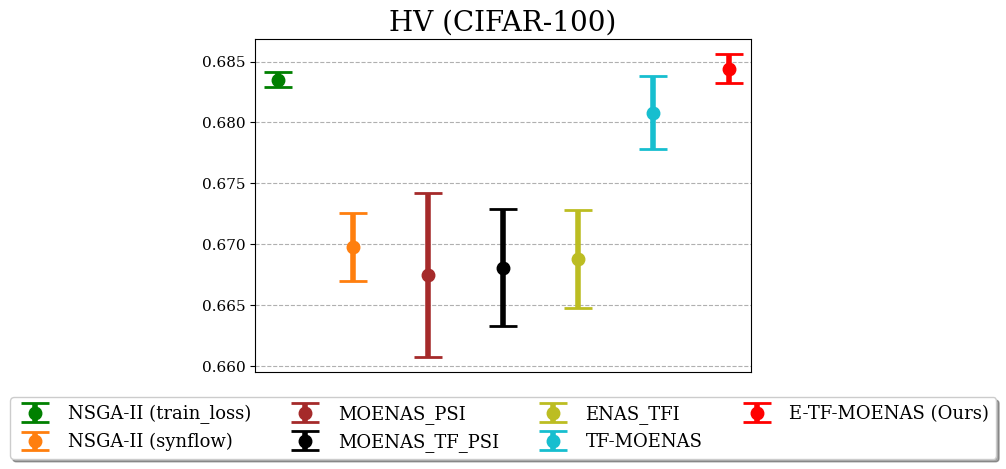

In [51]:
draw('HV')

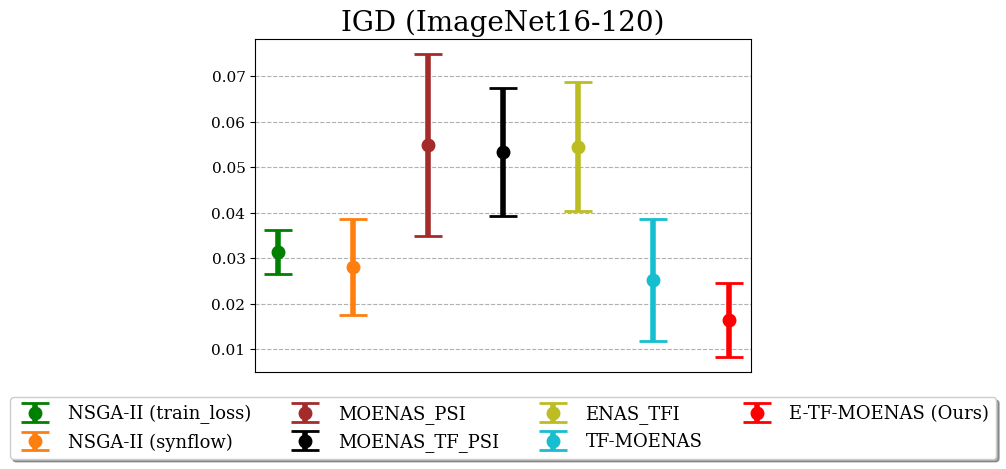

In [57]:
draw('IGD')

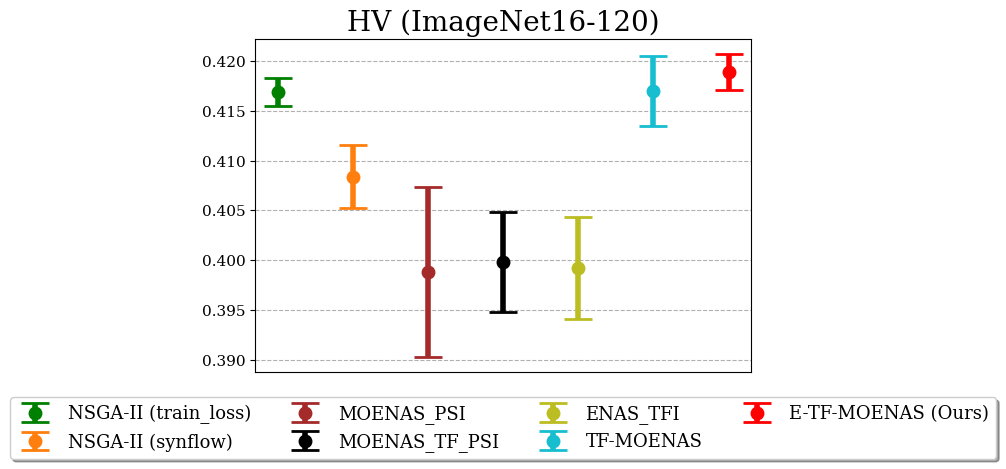

In [58]:
draw('HV')

## T-tests

In [14]:
alpha = 0.05


def return_IGD_HV(rs):
    return rs['final_IGD'], rs['final_HV']

def compare(x, y, name_x, name_y, metric='IGD', a=0.05):
    p_value = stats.ttest_ind(x, y)[-1]

    print(metric, name_x, name_y)
    print('p_value:', p_value)

    if np.isnan(p_value):
        p_value = 1
    if p_value <= a:
        mean_1 = np.mean(x)
        mean_2 = np.mean(y)
        std_1 = np.std(x)
        std_2 = np.std(y)
        cohen_d = (abs(mean_1 - mean_2)) / ((std_1 ** 2 + std_2 ** 2) / 2) ** (1 / 2)
        if cohen_d >= 0.8:
            effect_size = 'large'
        elif cohen_d >= 0.5:
            effect_size = 'medium'
        elif cohen_d >= 0.2:
            effect_size = 'small'
        else:
            effect_size = 'trivial'
        rs = np.mean(y) - np.mean(x)
        if metric in ['HV', 'best_arch_found']:
            rs *= -1
        if rs > 0:
            rs_compare = 'worse'
        else:
            rs_compare = 'better'
        print('Reject |', rs_compare, effect_size)
    print()

def print_mean_std(_all, round_pre=4):
    _mean = np.mean(_all, axis=0)
    _std = np.std(_all, axis=0)
    print(f'{np.round(_mean, round_pre)} ({np.round(_std, round_pre)})')

def print_best_arch_mean_std(rs):
    _mean = np.round(np.mean(rs['best_arch_found']), 2)
    _std = np.round(np.std(rs['best_arch_found']), 2)
    print(f'Best (mean & std): {_mean} ({_std})')

def run_t_test():
    print('Dataset:', dataset)

    list_variant = [
        'val_error', 'val_loss', 'train_loss',
        'moead-val_error', 'moead-val_loss', 'moead-train_loss',
        'synflow', 'jacov', 'snip', 'grad_norm', 'grasp', 'fisher',
        'ENAS_TFI', 'MOENAS_PSI', 'MOENAS_TF_PSI',
        'E-TF-MOENAS', 'E-TF-MOENAS-C'
    ]

    list_competitor = []
    for i, variant in enumerate(list_variant):
        if os.path.exists(RES_PATH + f'/{variant}_{dataset_abbrev}_T.p'):
            print(variant)
            res = p.load(open(RES_PATH + f'/{variant}_{dataset_abbrev}_T.p', 'rb'))

            igd, hv = return_IGD_HV(res)
            print('IGD: ', end='')
            print_mean_std(igd)
            print('HV: ', end='')
            print_mean_std(hv)
            print_best_arch_mean_std(res)
            performance = {
                'variant': variant,
                'IGD': igd,
                'HV': hv,
                'best_arch_found': res['best_arch_found']
            }
            list_competitor.append(performance)
            print('-' * 100)
    print('='*20)
    print()
    n_competitor = len(list_competitor)
    # n_competitors = 2
    print(f'Alpha: {alpha/n_competitor}\n')
    for metric in ['IGD', 'HV']:
        print('Metric:', metric)
        for i in range(len(list_competitor)):
            for j in range(i + 1, len(list_competitor)):
                pair = [list_competitor[i][metric], list_competitor[j][metric],
                        list_competitor[i]['variant'], list_competitor[j]['variant'], metric, alpha/n_competitor]
                compare(*pair)
        print('='*100)
        print()

In [15]:
run_t_test()

Dataset: CIFAR-100
train_loss
IGD: 0.0298 (0.0096)
HV: 0.6835 (0.0006)
Best (mean & std): 73.14 (0.12)
----------------------------------------------------------------------------------------------------
synflow
IGD: 0.0328 (0.0146)
HV: 0.6698 (0.0028)
Best (mean & std): 73.42 (0.28)
----------------------------------------------------------------------------------------------------
ENAS_TFI
IGD: 0.0754 (0.0226)
HV: 0.6688 (0.004)
Best (mean & std): 71.3 (0.7)
----------------------------------------------------------------------------------------------------
MOENAS_PSI
IGD: 0.0761 (0.0264)
HV: 0.6675 (0.0067)
Best (mean & std): 71.09 (1.04)
----------------------------------------------------------------------------------------------------
MOENAS_TF_PSI
IGD: 0.0749 (0.0246)
HV: 0.6681 (0.0048)
Best (mean & std): 71.13 (0.81)
----------------------------------------------------------------------------------------------------
E-TF-MOENAS
IGD: 0.0101 (0.0076)
HV: 0.6844 (0.0012)
Best (me